# Graphene-U-Net Usage Example


## Step 0: Install Dependencies

**NERSC Note:**
  * Use pytorch-1.71-gpu kernel
  * Uncomment the following cell when running the notebook for the first time to install the required OpenCV libraray

In [1]:
#%pip install --user opencv-python

## Step 1: Import Library

In [2]:
from Microscopy_Unet import Segmentation_Network

## Step 2: Instantiate Network

D is the 'Depth' of the network/number of down convolutional blocks (which will be followed with D-1 up convolutional blocks)

W is the network 'Width' which is the power of 2 number of features in the first block (which will be doubled for every subsequent block in the contraction path, and then divided by two in the contraction path)

model_name is the name of the model used to save the network which will also be used to save training progress data

save_freq is the frequency in terms of epochs how often the network will be saved to disk

In [3]:
network= Segmentation_Network(D = 4,       #network depth
                W = 5,                     #netork width
                LR = .0001,                #learning rate
                model_name = "UNET_GRPH",  #name model for checkpoints
                save_freq=10               #frequency of network checkpoint saves
               )


initializing model
>>>from blank slate


## Step 3: Load Training Data

Next, we load the training data from the `training_images/` folder using GetDataSet, where data_path is the path to the folder where the labeled training data is. The term 'handle' is the marker name for the labels of the training data. The naming convention of the training data is as such: For every input image "`filename.png`" in the data_path folder there should be a corresponding label image with the name "`filename_<handle>.png`". For example, if the handle is "`_LABEL`" then for a folder with input images named "`training_img_0.png`", "`training_img_1.png`" there should be corresponging files named "`training_img_0_LABEL.png`", "`training_img_1_LABEL.png`" to get proper behaivior.
    
Once data is loaded, it is important to shuffle it.

In [4]:
network.GetDataSet(data_path = "training_images/", handle="_LABEL") #load in dataset
network.DataShuffle(seed = 4)

## Step 4: Train Network

Now we train the network using K-Fold cross Validation where K = 4

In [5]:
network.Kfold(k=4, epochs=15)


==========RUNNING 4-FOLD CROSS VALIDATION==========

 ###############STARTING FOLD: 0 of 4###############

initializing model
>>>from blank slate

Evaluating... 

/global/u2/g/ghweber/devel/graphene-u-net/Microscopy_Unet.py:174: RuntimeWarning: invalid value encountered in true_divide
  img = img/np.max(img)


DICE class 0: 0.926 DICE class 1: 0.0
epoch:0		model:UNET_GRPH_fold_0		iteration:104		loss:0.56839 --> saving model

Evaluating... DICE class 0: 0.926 DICE class 1: 0.0
epoch:1		model:UNET_GRPH_fold_0		iteration:104		loss:0.11359
Evaluating... DICE class 0: 0.938 DICE class 1: 0.703
epoch:2		model:UNET_GRPH_fold_0		iteration:104		loss:0.08604
Evaluating... DICE class 0: 0.97 DICE class 1: 0.819
epoch:3		model:UNET_GRPH_fold_0		iteration:104		loss:0.17528
Evaluating... DICE class 0: 0.974 DICE class 1: 0.829
epoch:4		model:UNET_GRPH_fold_0		iteration:104		loss:0.04854
Evaluating... DICE class 0: 0.974 DICE class 1: 0.815
epoch:5		model:UNET_GRPH_fold_0		iteration:104		loss:0.08783
Evaluating... DICE class 0: 0.972 DICE class 1: 0.803
epoch:6		model:UNET_GRPH_fold_0		iteration:104		loss:0.08901
Evaluating... DICE class 0: 0.974 DICE class 1: 0.83
epoch:7		model:UNET_GRPH_fold_0		iteration:104		loss:0.09182
Evaluating... DICE class 0: 0.976 DICE class 1: 0.838
epoch:8		model:UNET_GRPH_fol

## Step 5: Visualize Training Progress Over Epochs

Data about the training progress is automatically saved in CSV Files associated with the network name for convenience of observing the progress over time. These can be loaded into the notebook using pandas and visualized using matplotlib.

In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from os import path

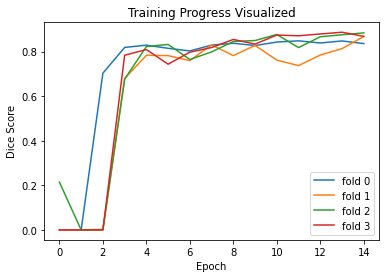

In [7]:
name = "UNET_GRPH"
plt.figure()

for fold in range(4):
    file = name+"_fold_"+str(fold)+".csv"
    if path.exists(file):
        data = pd.read_csv(file)['F1_1'].to_numpy()
        plt.plot(data, label = 'fold '+str(fold))

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training Progress Visualized')
plt.show()

## Step 6: Load and Use Model

Now that we have trained the model, we can load it and then run it on an example image. For simplicity we a re-use a training image.

First we load an image.

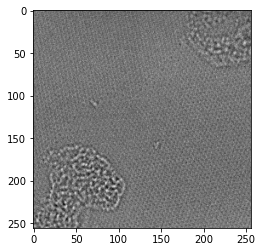

In [10]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("./training_images/2013_1114_Gr_FS_011_layer_0007.png", 0)
plt.imshow(img, cmap = 'gray')

Then, we load the trained model into a new network instance.

In [11]:
trained_network= Segmentation_Network(D = 4,   #network depth
                W = 5,                         #netork width
                LR = .0001,                    #learning rate
                model_name = "UNET_GRPH_demo", #name model for checkpoints
                save_freq=10,                  #frequency of network checkpoint saves
                load = "UNET_GRPH_fold_0.pth"  #path to trained network                              
               ) 


initializing model
>>>from saved model
loading model from UNET_GRPH_fold_0.pth
reseting optimizer


Finally, we use this model to predict the segmentation for the loaded image.

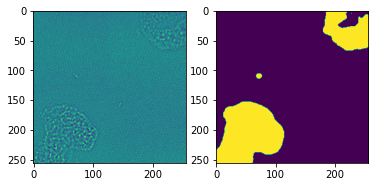

In [12]:
output = trained_network.infer(img)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(output)
plt.show()